# Libs

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, roc_auc_score, confusion_matrix
import copy
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn import metrics
import pandas as pd
import numpy as np
import gc
import optuna
from optuna.samplers import TPESampler

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load data

In [3]:
train_full = pd.read_pickle('/kaggle/input/data-aggregation-ipynb/create_feature_train_ver2.pkl')

temp, test = train_test_split(train_full, test_size = 0.15)
train, valid = train_test_split(temp, test_size = 0.2)
train.shape, valid.shape, test.shape

((209107, 534), (52277, 534), (46127, 534))

# Funcs

In [4]:
from scipy import special

def logloss_objective(preds, train_data):
    y = train_data.get_label()
    p = special.expit(preds)
    grad = p - y
    hess = p * (1 - p)
    return grad, hess

In [5]:
import numpy as np

def logloss_metric(preds, train_data):
    y = train_data.get_label()
    p = special.expit(preds)

    ll = np.empty_like(p)
    pos = y == 1
    ll[pos] = np.log(p[pos])
    ll[~pos] = np.log(1 - p[~pos])

    is_higher_better = False
    return 'logloss', -ll.mean(), is_higher_better

In [6]:
def logloss_init_score(y):
    p = y.mean()
    p = np.clip(p, 1e-15, 1 - 1e-15)  # never hurts
    log_odds = np.log(p / (1 - p))
    return log_odds

In [7]:
import numpy as np
from scipy import optimize
from scipy import special

class FocalLoss:

    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        return self.grad(y, p), self.hess(y, p)

    def lgb_eval(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better
    
def check_gradient(func, grad, values, eps=1e-8):
    approx = (func(values + eps) - func(values - eps)) / (2 * eps)
    return np.linalg.norm(approx - grad(values))

In [8]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def plotImp(model , num = 20, fig_size = (45, 25), font_scale = 4):
#     print(len(model.feature_importance()))
#     print(len(X.columns))
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type = 'gain'),
                                'Feature':model.feature_name()})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = font_scale)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [10]:
def cal_gini(model, data, features):
    pred = model.predict(data[features])
    auc = roc_auc_score(data['TARGET'], pred)
    gini = 2*auc - 1
    return gini 

# Demo

In [11]:
# fl = FocalLoss(alpha=external_params['alpha'], gamma=external_params['gamma'])
#             self.initial_score = fl.init_score(y_train)

fl = FocalLoss(alpha=0.26397127733472775, gamma=1)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

model_ver1 = lgb.train(
    params={'objective': 'binary',
        'boost_from_average': True, 
        'verbose': -1, 
        'boosting_type': 'gbdt',
        'max_bin': 300,
        'max_depth':7,
        'learning_rate': 0.018437,
        'num_leaves': 58,
        'reg_lambda': 4.930,
        'reg_alpha':3.564,
        'min_child_weight': 6,
        'min_split_gain':0.143,
    #     'min_data_in_leaf': mm 
        'colsample_bytree':0.613,
        'subsample':0.708},
    train_set=fit,
    num_boost_round=100,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=20,
    verbose_eval=10,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)


Training until validation scores don't improve for 20 rounds
[10]	fit's focal_loss: 0.0499628	val's focal_loss: 0.0493842
[20]	fit's focal_loss: 0.047945	val's focal_loss: 0.0475535
[30]	fit's focal_loss: 0.0466573	val's focal_loss: 0.046424
[40]	fit's focal_loss: 0.0457751	val's focal_loss: 0.0456693
[50]	fit's focal_loss: 0.0451258	val's focal_loss: 0.0451427
[60]	fit's focal_loss: 0.0446301	val's focal_loss: 0.0447539
[70]	fit's focal_loss: 0.0442298	val's focal_loss: 0.0444671
[80]	fit's focal_loss: 0.043904	val's focal_loss: 0.0442384
[90]	fit's focal_loss: 0.0436342	val's focal_loss: 0.0440615
[100]	fit's focal_loss: 0.0433979	val's focal_loss: 0.043911
Did not meet early stopping. Best iteration is:
[100]	fit's focal_loss: 0.0433979	val's focal_loss: 0.043911


In [13]:
y_pred = special.expit(fl.init_score(train['TARGET']) + model_ver1.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

print(f"Test's ROC AUC: {metrics.roc_auc_score(test['TARGET'], y_pred):.5f}")

Test's ROC AUC: 0.77431


# Optuna

In [22]:
def objective(trial):
    params_lgb = {
        "objective": "binary",
        "boost_from_average": True,
        "verbose": -1,
        "boosting_type": "gbdt",
        "max_bin": trial.suggest_int('max_bin', 10, 50),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1),
        "num_leaves": trial.suggest_int("num_leaves", 9, 20),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 5),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 5),
        "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 5000),
        'feature_fraction' : trial.suggest_loguniform('feature_fraction', 0.01, 1),
        'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-8, 5)
    }
    params_focal = {'alpha': trial.suggest_loguniform('alpha', 1e-3, 5),
                   'gamma': trial.suggest_loguniform('gamma', 1e-3, 5)}
    
    fl = FocalLoss(alpha=params_focal['alpha'], gamma=params_focal['gamma'])

    fit = lgb.Dataset(
        train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
        init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
    )

    val = lgb.Dataset(
        valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
        init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
        reference=fit
    )
    
    model_tune = lgb.train(params = params_lgb, train_set = fit, num_boost_round=1000,
                           valid_sets=(fit, val), valid_names = ('fit', 'val'),
                           early_stopping_rounds=50, verbose_eval = 100, 
                           fobj=fl.lgb_obj, feval=fl.lgb_eval)
    
    pred_valid = special.expit(fl.init_score(train['TARGET']) + model_tune.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
    gini_ = 2 * metrics.roc_auc_score(valid['TARGET'], pred_valid) - 1
    print('GINI ', gini_)
    del model_tune, fit, val
    gc.collect()
    return gini_


In [23]:
study_tuner1 = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), 
                            direction="maximize", sampler = TPESampler())
study_tuner1.optimize(objective, n_trials=20)
print(study_tuner1.best_trial)

[I 2023-05-11 17:09:53,612] A new study created in memory with name: no-name-64886903-05fb-4ddf-8906-cca83e0759b3


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0162408	val's focal_loss: 0.0162318
[200]	fit's focal_loss: 0.00555	val's focal_loss: 0.00551334
[300]	fit's focal_loss: 0.00386289	val's focal_loss: 0.00381709
[400]	fit's focal_loss: 0.0036212	val's focal_loss: 0.0035749
[500]	fit's focal_loss: 0.00356203	val's focal_loss: 0.00351982
[600]	fit's focal_loss: 0.00353278	val's focal_loss: 0.00349564
[700]	fit's focal_loss: 0.00351465	val's focal_loss: 0.00348338
[800]	fit's focal_loss: 0.00350135	val's focal_loss: 0.00347565
[900]	fit's focal_loss: 0.00349081	val's focal_loss: 0.00347054
[1000]	fit's focal_loss: 0.00348208	val's focal_loss: 0.00346689
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.00348208	val's focal_loss: 0.00346689
GINI  0.5773215324174861


[I 2023-05-11 17:15:13,297] Trial 0 finished with value: 0.5773215324174861 and parameters: {'max_bin': 45, 'max_depth': 6, 'learning_rate': 0.016577753354294032, 'num_leaves': 13, 'lambda_l2': 0.0003299932929276972, 'lambda_l1': 3.047429256935118e-05, 'min_gain_to_split': 0.016208684212598624, 'min_data_in_leaf': 3479, 'feature_fraction': 0.1902789837544067, 'min_sum_hessian_in_leaf': 8.252811312575927e-07, 'alpha': 0.0054395400218212805, 'gamma': 0.0030766498357651002}. Best is trial 0 with value: 0.5773215324174861.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.437697	val's focal_loss: 0.429435
GINI  0.0


[I 2023-05-11 17:15:41,327] Trial 1 finished with value: 0.0 and parameters: {'max_bin': 32, 'max_depth': 5, 'learning_rate': 0.8110749722889645, 'num_leaves': 20, 'lambda_l2': 1.5832887971927698e-05, 'lambda_l1': 3.809180674284934e-07, 'min_gain_to_split': 2.167527701033452e-05, 'min_data_in_leaf': 4503, 'feature_fraction': 0.13271263108553874, 'min_sum_hessian_in_leaf': 0.045745979306133396, 'alpha': 2.4472022460755083, 'gamma': 0.3658495791808574}. Best is trial 0 with value: 0.5773215324174861.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00116015	val's focal_loss: 0.00114443
[200]	fit's focal_loss: 0.00113749	val's focal_loss: 0.00112543
[300]	fit's focal_loss: 0.00112852	val's focal_loss: 0.00111893
[400]	fit's focal_loss: 0.00112159	val's focal_loss: 0.00111442
[500]	fit's focal_loss: 0.00111764	val's focal_loss: 0.00111255
[600]	fit's focal_loss: 0.00111388	val's focal_loss: 0.00111087
[700]	fit's focal_loss: 0.00111109	val's focal_loss: 0.00111042
[800]	fit's focal_loss: 0.00110846	val's focal_loss: 0.00110989
[900]	fit's focal_loss: 0.00110604	val's focal_loss: 0.0011095
[1000]	fit's focal_loss: 0.00110364	val's focal_loss: 0.00110946
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.00110364	val's focal_loss: 0.00110946
GINI  0.5824488051447589


[I 2023-05-11 17:17:10,246] Trial 2 finished with value: 0.5824488051447589 and parameters: {'max_bin': 39, 'max_depth': 3, 'learning_rate': 0.12300216277455132, 'num_leaves': 19, 'lambda_l2': 6.928365881920065e-08, 'lambda_l1': 6.655013834900467e-06, 'min_gain_to_split': 0.00013561498630149219, 'min_data_in_leaf': 3291, 'feature_fraction': 0.013036644211099863, 'min_sum_hessian_in_leaf': 7.489701915751155e-05, 'alpha': 0.001579502190832793, 'gamma': 0.05524653234303348}. Best is trial 2 with value: 0.5824488051447589.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.000340466	val's focal_loss: 0.00033739
[200]	fit's focal_loss: 0.000337481	val's focal_loss: 0.000334489
[300]	fit's focal_loss: 0.000336169	val's focal_loss: 0.000333247
[400]	fit's focal_loss: 0.000335738	val's focal_loss: 0.000332816
[500]	fit's focal_loss: 0.000335237	val's focal_loss: 0.000332323
[600]	fit's focal_loss: 0.000335054	val's focal_loss: 0.000332143
[700]	fit's focal_loss: 0.000334819	val's focal_loss: 0.000331895
[800]	fit's focal_loss: 0.000334728	val's focal_loss: 0.000331796
[900]	fit's focal_loss: 0.000334634	val's focal_loss: 0.000331708
Early stopping, best iteration is:
[933]	fit's focal_loss: 0.000334599	val's focal_loss: 0.000331661
GINI  0.5627927232690237


[I 2023-05-11 17:20:07,368] Trial 3 finished with value: 0.5627927232690237 and parameters: {'max_bin': 40, 'max_depth': 7, 'learning_rate': 0.15829634512117166, 'num_leaves': 19, 'lambda_l2': 3.343625123562444e-07, 'lambda_l1': 0.015482112347872548, 'min_gain_to_split': 0.014426849482633678, 'min_data_in_leaf': 4290, 'feature_fraction': 0.01913855235987096, 'min_sum_hessian_in_leaf': 0.860893185317127, 'alpha': 0.0022868183821126787, 'gamma': 3.1769592674272964}. Best is trial 2 with value: 0.5824488051447589.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0404152	val's focal_loss: 0.0401734
Early stopping, best iteration is:
[54]	fit's focal_loss: 0.0404152	val's focal_loss: 0.0401734
GINI  0.5615938843430173


[I 2023-05-11 17:20:54,588] Trial 4 finished with value: 0.5615938843430173 and parameters: {'max_bin': 10, 'max_depth': 8, 'learning_rate': 0.3276580697789789, 'num_leaves': 12, 'lambda_l2': 3.3288555863991484e-05, 'lambda_l1': 0.09131745045204531, 'min_gain_to_split': 1.7929826369850057, 'min_data_in_leaf': 3510, 'feature_fraction': 0.23639191878383625, 'min_sum_hessian_in_leaf': 2.7204325951411633e-05, 'alpha': 0.1017469042695285, 'gamma': 0.024379445044625424}. Best is trial 2 with value: 0.5824488051447589.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00374032	val's focal_loss: 0.00373446
[200]	fit's focal_loss: 0.00116076	val's focal_loss: 0.00114693
[300]	fit's focal_loss: 0.00105956	val's focal_loss: 0.00104558
[400]	fit's focal_loss: 0.00104391	val's focal_loss: 0.00103171
[500]	fit's focal_loss: 0.00103653	val's focal_loss: 0.00102631
[600]	fit's focal_loss: 0.00103181	val's focal_loss: 0.00102356
[700]	fit's focal_loss: 0.00102831	val's focal_loss: 0.00102202
[800]	fit's focal_loss: 0.00102543	val's focal_loss: 0.00102111
[900]	fit's focal_loss: 0.00102284	val's focal_loss: 0.00102045
[1000]	fit's focal_loss: 0.0010205	val's focal_loss: 0.00101999
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0010205	val's focal_loss: 0.00101999
GINI  0.582897490178415


[I 2023-05-11 17:24:48,313] Trial 5 finished with value: 0.582897490178415 and parameters: {'max_bin': 40, 'max_depth': 8, 'learning_rate': 0.02823053497101336, 'num_leaves': 12, 'lambda_l2': 7.052288062191644e-08, 'lambda_l1': 3.544444086492954e-06, 'min_gain_to_split': 7.702969693542334e-05, 'min_data_in_leaf': 1728, 'feature_fraction': 0.06825674659216845, 'min_sum_hessian_in_leaf': 3.30277235886956e-07, 'alpha': 0.001568231223979791, 'gamma': 0.15010900568018953}. Best is trial 5 with value: 0.582897490178415.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0218807	val's focal_loss: 0.0220312
[200]	fit's focal_loss: 0.0211559	val's focal_loss: 0.0217041
[300]	fit's focal_loss: 0.0207163	val's focal_loss: 0.0216809
Early stopping, best iteration is:
[272]	fit's focal_loss: 0.0208219	val's focal_loss: 0.0216666
GINI  0.5700378950529239


[I 2023-05-11 17:25:58,391] Trial 6 finished with value: 0.5700378950529239 and parameters: {'max_bin': 34, 'max_depth': 5, 'learning_rate': 0.21120162354102076, 'num_leaves': 12, 'lambda_l2': 0.00013101208522283748, 'lambda_l1': 0.38819619291892377, 'min_gain_to_split': 0.022546049138831348, 'min_data_in_leaf': 4443, 'feature_fraction': 0.016078070920279755, 'min_sum_hessian_in_leaf': 0.004391996460442149, 'alpha': 0.7825341029425307, 'gamma': 2.506511955091438}. Best is trial 5 with value: 0.582897490178415.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.075619	val's focal_loss: 0.0749417
[200]	fit's focal_loss: 0.0730525	val's focal_loss: 0.0726149
[300]	fit's focal_loss: 0.0714121	val's focal_loss: 0.0711686
[400]	fit's focal_loss: 0.0704128	val's focal_loss: 0.0703748
[500]	fit's focal_loss: 0.069709	val's focal_loss: 0.0698546
[600]	fit's focal_loss: 0.0691621	val's focal_loss: 0.0694992
[700]	fit's focal_loss: 0.0687008	val's focal_loss: 0.0692129
[800]	fit's focal_loss: 0.0683184	val's focal_loss: 0.0690121
[900]	fit's focal_loss: 0.0679823	val's focal_loss: 0.0688556
[1000]	fit's focal_loss: 0.0676794	val's focal_loss: 0.0687306
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0676794	val's focal_loss: 0.0687306
GINI  0.5771859269824584


[I 2023-05-11 17:30:03,158] Trial 7 finished with value: 0.5771859269824584 and parameters: {'max_bin': 41, 'max_depth': 6, 'learning_rate': 0.011810362596595817, 'num_leaves': 20, 'lambda_l2': 2.733232626177561e-08, 'lambda_l1': 3.3708216149332455, 'min_gain_to_split': 2.967995863480102e-05, 'min_data_in_leaf': 233, 'feature_fraction': 0.07839760917634694, 'min_sum_hessian_in_leaf': 9.861901520816615e-05, 'alpha': 0.29633275450455715, 'gamma': 0.3567999347238537}. Best is trial 5 with value: 0.582897490178415.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: -7.61125	val's focal_loss: -7.49601
GINI  -0.1994259189750519


[I 2023-05-11 17:30:26,322] Trial 8 finished with value: -0.1994259189750519 and parameters: {'max_bin': 27, 'max_depth': 5, 'learning_rate': 0.02863521375703782, 'num_leaves': 15, 'lambda_l2': 0.20854255359755833, 'lambda_l1': 1.8737501795875264, 'min_gain_to_split': 1.3071767844944358e-06, 'min_data_in_leaf': 4264, 'feature_fraction': 0.024359161732928562, 'min_sum_hessian_in_leaf': 1.0884679673612975e-08, 'alpha': 1.7718621599741406, 'gamma': 1.808421226671669}. Best is trial 5 with value: 0.582897490178415.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	fit's focal_loss: 0.577357	val's focal_loss: 0.567043
GINI  0.0


[I 2023-05-11 17:30:52,520] Trial 9 finished with value: 0.0 and parameters: {'max_bin': 45, 'max_depth': 6, 'learning_rate': 0.015045105329297514, 'num_leaves': 14, 'lambda_l2': 0.0020291095642362227, 'lambda_l1': 0.31330885686166904, 'min_gain_to_split': 0.0014550151781665998, 'min_data_in_leaf': 2659, 'feature_fraction': 0.09315680684458533, 'min_sum_hessian_in_leaf': 2.775733963886009e-06, 'alpha': 3.1607976402903173, 'gamma': 0.7214453125838538}. Best is trial 5 with value: 0.582897490178415.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00891638	val's focal_loss: 0.00879935
[200]	fit's focal_loss: 0.00860857	val's focal_loss: 0.00853133
[300]	fit's focal_loss: 0.00851686	val's focal_loss: 0.00847965
[400]	fit's focal_loss: 0.00845832	val's focal_loss: 0.00845835
[500]	fit's focal_loss: 0.00841112	val's focal_loss: 0.00844974
[600]	fit's focal_loss: 0.00837047	val's focal_loss: 0.00844586
[700]	fit's focal_loss: 0.00833087	val's focal_loss: 0.00844248
[800]	fit's focal_loss: 0.00829387	val's focal_loss: 0.00844173
[900]	fit's focal_loss: 0.00825787	val's focal_loss: 0.0084407
Early stopping, best iteration is:
[909]	fit's focal_loss: 0.00825478	val's focal_loss: 0.00844023
GINI  0.5853086805294898


[I 2023-05-11 17:36:05,710] Trial 10 finished with value: 0.5853086805294898 and parameters: {'max_bin': 23, 'max_depth': 10, 'learning_rate': 0.0517255856665655, 'num_leaves': 9, 'lambda_l2': 1.0070264431084341e-06, 'lambda_l1': 1.9182297858017444e-08, 'min_gain_to_split': 2.589635355816975e-06, 'min_data_in_leaf': 1153, 'feature_fraction': 0.8033062048535533, 'min_sum_hessian_in_leaf': 1.0205787776801535e-08, 'alpha': 0.015377280233522814, 'gamma': 0.012468944895217432}. Best is trial 10 with value: 0.5853086805294898.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00862269	val's focal_loss: 0.00851081
[200]	fit's focal_loss: 0.00831139	val's focal_loss: 0.00823818
[300]	fit's focal_loss: 0.00821996	val's focal_loss: 0.00818655
[400]	fit's focal_loss: 0.00816308	val's focal_loss: 0.0081675
[500]	fit's focal_loss: 0.00811791	val's focal_loss: 0.00815729
[600]	fit's focal_loss: 0.00807725	val's focal_loss: 0.00815427
[700]	fit's focal_loss: 0.00803902	val's focal_loss: 0.00814895
Early stopping, best iteration is:
[708]	fit's focal_loss: 0.00803615	val's focal_loss: 0.00814862
GINI  0.5822504416585343


[I 2023-05-11 17:40:14,510] Trial 11 finished with value: 0.5822504416585343 and parameters: {'max_bin': 23, 'max_depth': 10, 'learning_rate': 0.051043763202087845, 'num_leaves': 9, 'lambda_l2': 8.843768879427707e-07, 'lambda_l1': 2.082718694460352e-08, 'min_gain_to_split': 1.451201214462049e-08, 'min_data_in_leaf': 1162, 'feature_fraction': 0.9976430964486862, 'min_sum_hessian_in_leaf': 1.0846317750712546e-08, 'alpha': 0.014715554082715533, 'gamma': 0.010114136400405363}. Best is trial 10 with value: 0.5853086805294898.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0082998	val's focal_loss: 0.00819016
[200]	fit's focal_loss: 0.00806579	val's focal_loss: 0.00799521
[300]	fit's focal_loss: 0.00798535	val's focal_loss: 0.00795526
[400]	fit's focal_loss: 0.00793281	val's focal_loss: 0.00794064
[500]	fit's focal_loss: 0.00788988	val's focal_loss: 0.00793248
[600]	fit's focal_loss: 0.0078505	val's focal_loss: 0.00792756
[700]	fit's focal_loss: 0.00781385	val's focal_loss: 0.00792503
[800]	fit's focal_loss: 0.00777952	val's focal_loss: 0.00792421
Early stopping, best iteration is:
[811]	fit's focal_loss: 0.00777589	val's focal_loss: 0.00792347
GINI  0.5828047844255937


[I 2023-05-11 17:44:53,869] Trial 12 finished with value: 0.5828047844255937 and parameters: {'max_bin': 19, 'max_depth': 10, 'learning_rate': 0.05433921531656847, 'num_leaves': 9, 'lambda_l2': 2.0881678129543976e-08, 'lambda_l1': 1.4710688964880964e-08, 'min_gain_to_split': 9.085803486667062e-07, 'min_data_in_leaf': 1434, 'feature_fraction': 0.769502628512258, 'min_sum_hessian_in_leaf': 2.3377954384890725e-07, 'alpha': 0.015851285938151338, 'gamma': 0.12341116181803881}. Best is trial 10 with value: 0.5853086805294898.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00105699	val's focal_loss: 0.00104573
[200]	fit's focal_loss: 0.000875592	val's focal_loss: 0.000864824
[300]	fit's focal_loss: 0.000866147	val's focal_loss: 0.000859013
[400]	fit's focal_loss: 0.000861092	val's focal_loss: 0.000857353
[500]	fit's focal_loss: 0.000857264	val's focal_loss: 0.00085671
[600]	fit's focal_loss: 0.000853859	val's focal_loss: 0.000856265
[700]	fit's focal_loss: 0.000850773	val's focal_loss: 0.000856148
[800]	fit's focal_loss: 0.000847703	val's focal_loss: 0.000856026
Early stopping, best iteration is:
[795]	fit's focal_loss: 0.000847833	val's focal_loss: 0.000856007
GINI  0.5806071315967269


[I 2023-05-11 17:50:59,467] Trial 13 finished with value: 0.5806071315967269 and parameters: {'max_bin': 16, 'max_depth': 9, 'learning_rate': 0.055974768694613125, 'num_leaves': 10, 'lambda_l2': 9.259924887646951e-07, 'lambda_l1': 8.59614874897439e-07, 'min_gain_to_split': 1.7166390707739783e-06, 'min_data_in_leaf': 1598, 'feature_fraction': 0.4570254411666105, 'min_sum_hessian_in_leaf': 5.948577093441265e-08, 'alpha': 0.0011220225858437464, 'gamma': 0.002052882980188387}. Best is trial 10 with value: 0.5853086805294898.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0122871	val's focal_loss: 0.0121732
[200]	fit's focal_loss: 0.0102067	val's focal_loss: 0.0100787
[300]	fit's focal_loss: 0.00995289	val's focal_loss: 0.00984428
[400]	fit's focal_loss: 0.00983783	val's focal_loss: 0.0097524
[500]	fit's focal_loss: 0.00976323	val's focal_loss: 0.0097014
[600]	fit's focal_loss: 0.00971119	val's focal_loss: 0.00967264
[700]	fit's focal_loss: 0.00966919	val's focal_loss: 0.00965528
[800]	fit's focal_loss: 0.00963322	val's focal_loss: 0.00964325
[900]	fit's focal_loss: 0.00959963	val's focal_loss: 0.00963298
[1000]	fit's focal_loss: 0.00956995	val's focal_loss: 0.00962736
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.00956995	val's focal_loss: 0.00962736
GINI  0.5805584265445538


[I 2023-05-11 17:54:33,449] Trial 14 finished with value: 0.5805584265445538 and parameters: {'max_bin': 27, 'max_depth': 8, 'learning_rate': 0.029781426703049396, 'num_leaves': 11, 'lambda_l2': 4.016387442877841e-06, 'lambda_l1': 0.0006746862837573797, 'min_gain_to_split': 8.14640301031537e-08, 'min_data_in_leaf': 473, 'feature_fraction': 0.04694401068419638, 'min_sum_hessian_in_leaf': 2.8079751454506715e-06, 'alpha': 0.017873927649527742, 'gamma': 0.010097777797269529}. Best is trial 10 with value: 0.5853086805294898.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00283795	val's focal_loss: 0.00280601
[200]	fit's focal_loss: 0.00276346	val's focal_loss: 0.00276055
[300]	fit's focal_loss: 0.00273127	val's focal_loss: 0.00275531
Early stopping, best iteration is:
[330]	fit's focal_loss: 0.00272305	val's focal_loss: 0.00275399
GINI  0.5822390110852536


[I 2023-05-11 17:57:17,064] Trial 15 finished with value: 0.5822390110852536 and parameters: {'max_bin': 36, 'max_depth': 9, 'learning_rate': 0.07409487111362478, 'num_leaves': 16, 'lambda_l2': 1.538036901559128e-08, 'lambda_l1': 1.8685866986361995e-07, 'min_gain_to_split': 1.821024025749644e-05, 'min_data_in_leaf': 2104, 'feature_fraction': 0.34754597383743785, 'min_sum_hessian_in_leaf': 8.933017123537134e-08, 'alpha': 0.004567855123240198, 'gamma': 0.09337275890519287}. Best is trial 10 with value: 0.5853086805294898.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0234794	val's focal_loss: 0.023209
[200]	fit's focal_loss: 0.021904	val's focal_loss: 0.0216143
[300]	fit's focal_loss: 0.0213974	val's focal_loss: 0.0211176
[400]	fit's focal_loss: 0.0211728	val's focal_loss: 0.0209073
[500]	fit's focal_loss: 0.0210312	val's focal_loss: 0.0207778
[600]	fit's focal_loss: 0.0209371	val's focal_loss: 0.0206995
[700]	fit's focal_loss: 0.0208636	val's focal_loss: 0.0206391
[800]	fit's focal_loss: 0.0208097	val's focal_loss: 0.0205987
[900]	fit's focal_loss: 0.0207627	val's focal_loss: 0.0205644
[1000]	fit's focal_loss: 0.0207238	val's focal_loss: 0.0205361
Did not meet early stopping. Best iteration is:
[1000]	fit's focal_loss: 0.0207238	val's focal_loss: 0.0205361
GINI  0.5685750419137703


[I 2023-05-11 18:00:39,337] Trial 16 finished with value: 0.5685750419137703 and parameters: {'max_bin': 50, 'max_depth': 2, 'learning_rate': 0.029422264383842437, 'num_leaves': 11, 'lambda_l2': 2.1401525531041412e-07, 'lambda_l1': 6.46125759865601e-06, 'min_gain_to_split': 0.00046458953985431084, 'min_data_in_leaf': 774, 'feature_fraction': 0.04261962502419465, 'min_sum_hessian_in_leaf': 4.015509798406575e-06, 'alpha': 0.044686876551708214, 'gamma': 0.030492552698568445}. Best is trial 10 with value: 0.5853086805294898.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0025386	val's focal_loss: 0.00250965
[200]	fit's focal_loss: 0.00247416	val's focal_loss: 0.00247403
[300]	fit's focal_loss: 0.0024441	val's focal_loss: 0.00246982
Early stopping, best iteration is:
[331]	fit's focal_loss: 0.00243601	val's focal_loss: 0.00246925
GINI  0.5832035833145659


[I 2023-05-11 18:03:45,084] Trial 17 finished with value: 0.5832035833145659 and parameters: {'max_bin': 29, 'max_depth': 8, 'learning_rate': 0.07599295342222209, 'num_leaves': 17, 'lambda_l2': 1.8414738326830779e-06, 'lambda_l1': 1.0234081769700165e-08, 'min_gain_to_split': 3.0671695271150047e-07, 'min_data_in_leaf': 2096, 'feature_fraction': 0.4769076425349817, 'min_sum_hessian_in_leaf': 2.2750636749538736e-07, 'alpha': 0.004292146970386368, 'gamma': 0.16246968530238087}. Best is trial 10 with value: 0.5853086805294898.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00375457	val's focal_loss: 0.00372127
[200]	fit's focal_loss: 0.00367017	val's focal_loss: 0.00369009
[300]	fit's focal_loss: 0.00361981	val's focal_loss: 0.00368731
Early stopping, best iteration is:
[298]	fit's focal_loss: 0.00362079	val's focal_loss: 0.00368722
GINI  0.5827193954407828


[I 2023-05-11 18:06:47,297] Trial 18 finished with value: 0.5827193954407828 and parameters: {'max_bin': 21, 'max_depth': 9, 'learning_rate': 0.09389701188433953, 'num_leaves': 17, 'lambda_l2': 4.965416769777196e-06, 'lambda_l1': 6.590716547989094e-08, 'min_gain_to_split': 1.832437551623607e-07, 'min_data_in_leaf': 2587, 'feature_fraction': 0.5621759047871718, 'min_sum_hessian_in_leaf': 1.0646285980856084e-08, 'alpha': 0.00586760537497742, 'gamma': 0.006750981611124049}. Best is trial 10 with value: 0.5853086805294898.


Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.0216044	val's focal_loss: 0.0215899
[200]	fit's focal_loss: 0.0210684	val's focal_loss: 0.0214614
Early stopping, best iteration is:
[224]	fit's focal_loss: 0.0209702	val's focal_loss: 0.0214504
GINI  0.5829369366664168


[I 2023-05-11 18:08:50,549] Trial 19 finished with value: 0.5829369366664168 and parameters: {'max_bin': 27, 'max_depth': 10, 'learning_rate': 0.0973185969240674, 'num_leaves': 17, 'lambda_l2': 2.0556957439974948e-06, 'lambda_l1': 1.0437948428065436e-08, 'min_gain_to_split': 2.0485941700221425e-08, 'min_data_in_leaf': 2200, 'feature_fraction': 0.35964523590266445, 'min_sum_hessian_in_leaf': 8.470344873084977e-06, 'alpha': 0.04612958014690384, 'gamma': 0.0013662177973303418}. Best is trial 10 with value: 0.5853086805294898.


FrozenTrial(number=10, state=TrialState.COMPLETE, values=[0.5853086805294898], datetime_start=datetime.datetime(2023, 5, 11, 17, 30, 52, 522366), datetime_complete=datetime.datetime(2023, 5, 11, 17, 36, 5, 709035), params={'max_bin': 23, 'max_depth': 10, 'learning_rate': 0.0517255856665655, 'num_leaves': 9, 'lambda_l2': 1.0070264431084341e-06, 'lambda_l1': 1.9182297858017444e-08, 'min_gain_to_split': 2.589635355816975e-06, 'min_data_in_leaf': 1153, 'feature_fraction': 0.8033062048535533, 'min_sum_hessian_in_leaf': 1.0205787776801535e-08, 'alpha': 0.015377280233522814, 'gamma': 0.012468944895217432}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_bin': IntDistribution(high=50, log=False, low=10, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'num_leaves': IntDistribution(high=20, log=False, low=9, step=1), 'lambda_l2': FloatDistribution(high=5.0, log=True,

In [24]:
study_tuner1.best_trial

FrozenTrial(number=10, state=TrialState.COMPLETE, values=[0.5853086805294898], datetime_start=datetime.datetime(2023, 5, 11, 17, 30, 52, 522366), datetime_complete=datetime.datetime(2023, 5, 11, 17, 36, 5, 709035), params={'max_bin': 23, 'max_depth': 10, 'learning_rate': 0.0517255856665655, 'num_leaves': 9, 'lambda_l2': 1.0070264431084341e-06, 'lambda_l1': 1.9182297858017444e-08, 'min_gain_to_split': 2.589635355816975e-06, 'min_data_in_leaf': 1153, 'feature_fraction': 0.8033062048535533, 'min_sum_hessian_in_leaf': 1.0205787776801535e-08, 'alpha': 0.015377280233522814, 'gamma': 0.012468944895217432}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_bin': IntDistribution(high=50, log=False, low=10, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'num_leaves': IntDistribution(high=20, log=False, low=9, step=1), 'lambda_l2': FloatDistribution(high=5.0, log=True,

In [25]:
study_tuner1.best_params

{'max_bin': 23,
 'max_depth': 10,
 'learning_rate': 0.0517255856665655,
 'num_leaves': 9,
 'lambda_l2': 1.0070264431084341e-06,
 'lambda_l1': 1.9182297858017444e-08,
 'min_gain_to_split': 2.589635355816975e-06,
 'min_data_in_leaf': 1153,
 'feature_fraction': 0.8033062048535533,
 'min_sum_hessian_in_leaf': 1.0205787776801535e-08,
 'alpha': 0.015377280233522814,
 'gamma': 0.012468944895217432}

# Evaluation

In [27]:
fl = FocalLoss(alpha=0.015377280233522814, gamma=0.012468944895217432)

fit = lgb.Dataset(
    train.drop(['SK_ID_CURR', 'TARGET'],axis=1), train.TARGET,
    init_score=np.full_like(train.TARGET, logloss_init_score(train.TARGET), dtype=float)
)

val = lgb.Dataset(
    valid.drop(['SK_ID_CURR', 'TARGET'],axis=1), valid.TARGET,
    init_score=np.full_like(valid.TARGET, logloss_init_score(train.TARGET), dtype=float),
    reference=fit
)

params = {
    'objective': 'binary',
    'boost_from_average': True,
    'max_bin': 23,
     'max_depth': 10,
     'learning_rate': 0.0517255856665655,
     'num_leaves': 9,
     'lambda_l2': 1.0070264431084341e-06,
     'lambda_l1': 1.9182297858017444e-08,
     'min_gain_to_split': 2.589635355816975e-06,
     'min_data_in_leaf': 1153,
     'feature_fraction': 0.8033062048535533,
     'min_sum_hessian_in_leaf': 1.0205787776801535e-08
}

model_ver2 = lgb.train(
    params= params,
    train_set=fit,
    num_boost_round=1000,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    early_stopping_rounds=50,
    verbose_eval=100,
    fobj=fl.lgb_obj,
    feval=fl.lgb_eval
)


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.942363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10557
[LightGBM] [Info] Number of data points in the train set: 209107, number of used features: 507
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 50 rounds
[100]	fit's focal_loss: 0.00891638	val's focal_loss: 0.00879935
[200]	fit's focal_loss: 0.00860857	val's focal_loss: 0.00853133
[300]	fit's focal_loss: 0.00851686	val's focal_loss: 0.00847965
[400]	fit's focal_loss: 0.00845832	val's focal_loss: 0.00845835
[500]	fit's focal_loss: 0.00841112	val's focal_loss: 0.00844974
[600]	fit's focal_loss: 0.00837047	val's focal_loss: 0.00844586
[700]	fit's focal_loss: 0.00833087	val's focal_loss: 0.00844248
[800]	fit's focal_loss: 0.00829387	val's focal_loss: 0.00844173
[900]	fit's fo

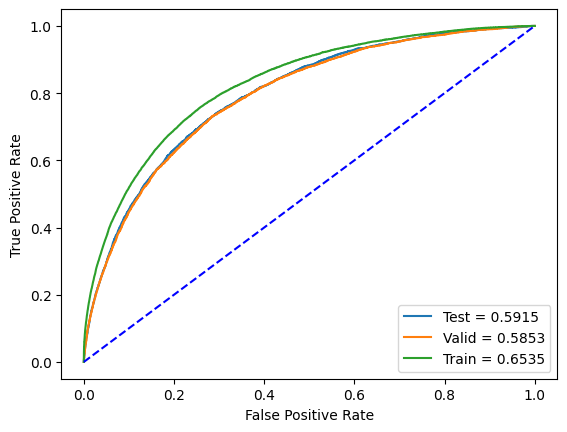

In [30]:
# y_pred = special.expit(fl.init_score(train['TARGET']) + model_ver1.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

pred_test = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_valid = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1)))
pred_train = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1)))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [31]:
df_feature_importance = (
    pd.DataFrame({
        'feature': model_ver2.feature_name(),
        'importance': model_ver2.feature_importance('gain'),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance.sort_values(by = 'importance', ascending=False)

,feature,importance
120,APPS_EXT_SOURCE_MEAN,1238.690270
41,EXT_SOURCE_3,191.283928
40,EXT_SOURCE_2,125.508085
123,APPS_GOODS_CREDIT_RATIO,99.165639
122,APPS_ANNUITY_CREDIT_RATIO,84.123073
...,...,...
109,FLAG_DOCUMENT_17,0.000000
314,BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM,0.000000
519,CARD_M3SK_DPD_MEAN,0.000000
491,CARD_DRAWING_LIMIT_RATIO_MAX,0.000000


In [32]:
df_feature_importance.to_excel('df_feature_importance_ver2.xlsx')

In [34]:
test_kaggle = pd.read_pickle('/kaggle/input/data-aggregation-ipynb/create_feature_test_kaggle_ver2.pkl')
# pred = model_ver2.predict(test_kaggle[logic_var])
pred = special.expit(fl.init_score(train['TARGET']) + model_ver2.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1)))
test_kaggle['TARGET'] = pred
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_lgb_focal_loss_ver2.csv', index = False)